In [2]:
 """
 NOTE: For TPU only
 Must go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python
 """
 #! pip install cloud-tpu-client==0.10.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

'\nNOTE: For TPU only\nMust go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python\n'

After expanding the sequence length, we quickly overran the available GPU RAM. Below, we import tools for utilizing mixed precision training to easily conserve memory. We also implemented gradient accumulation for the same purpose. 

In [3]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd

In [6]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [8]:
#import torch_xla.core.xla_model as xm

In [9]:
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn

from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import BigBirdModel, BigBirdTokenizerFast
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [10]:
#device = xm.xla_device()

#check is gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('gpu available')
else:
    device = torch.device('cpu')
    print('gpu not available')

gpu available


Our first attempt involved creating full transcripts for each case and exporting them as CSVs, which we then loaded into the script as needed. This exceeded the memory limits of Google Colab's TPUs and GPUs during training. 

We then tried a similar process but with the the "utterance" transcripts -- essentially lengths of text spoken by one person. Here, however, the RAM limit was exceeded when using the package that creates the utterance objects. We do not know why the RAM was exceeded here given that we were able to run the package locally on machines with lower amounts of RAM. 

Our third attempt was to create a dataframe of all utterances and the associated text and export it as a csv, roughly 1.7 million lines and 0.6GB as opposed to the packages ~7.3GB. 

In [11]:
# set to run with utterances or conversations 
utts = False

In [12]:
# create dataframe of utterances by case
df_utt = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')

# create dataframe by conversation record
df_convo = pd.read_csv('/content/drive/MyDrive/INFO251Final/Outcomes_NoTranscript.csv')

# create datafrae of Martin Quinn scores to merge with dataframes
martin_quinn = pd.read_csv('/content/drive/MyDrive/INFO251Final/MartinQuinnScores.csv')

df_args = pd.read_csv('/content/drive/MyDrive/INFO251Final/ArgumentsTable.csv')

<ipython-input-12-1a00a5baf015>:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_utt = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')


In [13]:
def clean_utts(df_utt):
    # updating columns

    # rename columns
    df_utt = df_utt.rename(columns={'meta.votes_side': 'votes_side',
                                      'meta.win_side': 'win_side',
                                      'meta.case_id': 'case_id',
                                      'med': 'mq_score', 
                                      'conversation_id': 'convo_id',
                                      'term_year': 'term'})

    df_utt.term = df_utt.term.astype('int64')

    # add MartinQuinn Scores
    df_utt = df_utt.merge(martin_quinn[['term', 'med']], on='term')

    # drop unused columns
    # NOTE we may want to try an analysis on some of these later on
    df_utt = df_utt.drop(columns=['speaker', 
                                  'reply_to', 
                                  'timestamp', 
                                  'meta.start_times', 
                                  'meta.stop_times', 
                                  'meta.speaker_type',
                                  'meta.side',
                                  'meta.timestamp',
                                  'vectors',
                                  'Unnamed: 0'])


    # add "win_side" to utterance dataframe
    

    #df_utt.drop(columns=['Unnamed: 0'])df_utt = df_utt.merge(df_convo[['convo_id', 'win_side']], on='convo_id')
    df_utt = df_utt.rename(columns={'text': 'words'})

    # Remove instances where case outcome was unknown or ????
    df_utt.drop(df_utt[df_utt['win_side'] == -1.0].index, inplace = True)
    df_utt.drop(df_utt[df_utt['win_side'] == 2.0].index, inplace = True)

    # Remove null values from the few cases with incomplete data
    df_utt = df_utt.dropna()

    return df_utt

In [16]:
df_utt = clean_utts(df_utt)

KeyError: ignored

In [17]:
def clean_convos(df_convo):
  # Remove instances where case outcome was unknown or ????
  df_convo.drop(df_convo[df_convo['win_side'] == -1.0].index, inplace = True)
  df_convo.drop(df_convo[df_convo['win_side'] == 2.0].index, inplace = True)

  # convert term from object to int
  df_convo.term = df_convo.term.astype('int64')

  # drop unused columns
  # NOTE we may want to try an analysis on some of these later on. Save memory now
  df_convo = df_convo.drop(columns=['Unnamed: 0', 'vectors', 'advocates', 'votes_side'])

  # 3 cases have null data due to oddities of transcribing data pre-digital transcripts
  df_convo = df_convo.dropna()

  return df_convo

In [18]:
df_convo = clean_convos(df_convo)

In [19]:
# Take a sample of df_convos or df_utts to test on
df_test = df_convo.sample(n=7000, replace=False, random_state=12)

In [20]:
##### Delete for now
del(df_utt)

In [21]:
# create a helper function that gets a random contiguous chunk of words from a transcript

random.seed(123)

def get_random_chunk(text, n_mean=1500, n_stddev=75):
    words = text.split()

    n = int(np.random.normal(n_mean, n_stddev))
    n = max(1, min(n, len(words))) # Ensure n is between 1 and the number of words in the text

    if len(words) <= n:
        return text

    start = random.randint(0, len(words) - n)
    end = start + n
    return " ".join(words[start:end])

In [22]:
# pull transcripts for each utterance or conversation and store in "words" column
# This method separately creates the transcripts for each conversation and stores them in a 
# separate folder for reference. Although this allowed for easy grouping by case, it 
# overwhelmed memory allocations 

def add_transcripts(df_test, utts=False):
  for index, row in df_test.iterrows():


    if utts:
      folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_uttid_caseid/'
      read_path = folder_path+str(row['utt_id'])+'_'+str(row['case_id'])+'.txt'

      transcript = open(read_path, 'r')
      text = transcript.read()

      text = get_random_chunk(text)
      
      df_test.loc[index, 'words'] = text

      transcript.close()

    else:
      folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_Case_Convo/'
      read_path = folder_path+str(row['convo_id'])+'_'+str(row['case_id'])+'.txt'

      transcript = open(read_path, 'r')
      text = transcript.read()

      text = get_random_chunk(text)

      df_test.at[index, 'words'] = text
  
      transcript.close()

  return df_test
    

In [23]:
# df_test = add_transcripts(df_test)
df_args.head()

,Unnamed: 0,vectors,meta.case_id,meta.advocates,meta.win_side,meta.votes_side,convo_id,case_transcript
0,0,[],1955_71,"{'harry_f_murphy': {'side': 1, 'role': 'inferr...",0.0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13127,"Number 71, Lonnie Affronti versus United State..."
1,1,[],1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",12997,"Number 410, American Airlines, Incorporated ve..."
2,2,[],1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13024,"Number 410, American Airlines, Incorporated ve..."
3,3,[],1955_351,"{'harry_d_graham': {'side': 3, 'role': 'inferr...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13015,"Number 351, R.V. Archawski et al. versus Basil..."
4,4,[],1955_38,"{'robert_n_gorman': {'side': 3, 'role': 'infer...",0.0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13016,"Number 38, Raymond C. Armstrong versus Mary R...."


In [24]:
df_args = df_args.rename(columns={'meta.case_id': 'case_id', 'case_transcript': 'words'})
df_test = df_test.merge(df_args[['convo_id', 'words']], on='convo_id')


In [25]:
df_test.head()

,case_id,win_side,convo_id,term,docket_id,mq_score,words
0,1960_42,1.0,14077,1960,42,0.443,"Number 42, Small Business Administration, Peti..."
1,2008_07-1209,1.0,23187,2008,07-1209,0.576,We will hear argument first this morning in Ca...
2,1967_363,1.0,14890,1967,363,-1.043,"Number 363, United States et al.Petitioner, ve..."
3,1976_76-128,1.0,16443,1976,76-128,0.473,"We will hear arguments next in 76-128, Mandel,..."
4,2014_13-6827,1.0,23221,2014,13-6827,-0.227,We'll hear argument first this morning in Case...


In [26]:
# df_test.to_csv('/content/drive/MyDrive/INFO251Final/TestConvoTranscripts.csv')

In [27]:
# convert to int for later reference by language models 
df_test['win_side'] = df_test['win_side'].astype(int)

In [28]:
df_test.head()

,case_id,win_side,convo_id,term,docket_id,mq_score,words
0,1960_42,1,14077,1960,42,0.443,"Number 42, Small Business Administration, Peti..."
1,2008_07-1209,1,23187,2008,07-1209,0.576,We will hear argument first this morning in Ca...
2,1967_363,1,14890,1967,363,-1.043,"Number 363, United States et al.Petitioner, ve..."
3,1976_76-128,1,16443,1976,76-128,0.473,"We will hear arguments next in 76-128, Mandel,..."
4,2014_13-6827,1,23221,2014,13-6827,-0.227,We'll hear argument first this morning in Case...


In [29]:
import gc
gc.collect()

84

In [30]:
#### ONLY FOR UTTERANCES
# Run train test split with conversation grouping 

if utts:
  gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=123)

In [31]:
# create train and temp split. Temp split will be split in half into testing and validation sets
# for train_idx, test_idx in gss.split(df_test, groups=df_test['convo_id']):
#     train_df = df_test.iloc[train_idx]
#     temp_df = df_test.iloc[test_idx]

In [32]:
# split dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_test['words'], 
                                                                    df_test['win_side'], 
                                                                    random_state=123, 
                                                                    test_size=0.3)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, 
                                                                temp_labels, 
                                                                random_state=123, 
                                                                test_size=0.5)

In [33]:
train_labels

2977    1
1139    1
5666    1
5824    1
4467    0
       ..
5218    1
4060    1
1346    0
3454    0
3582    1
Name: win_side, Length: 4900, dtype: int64

In [34]:
%who

AutoModel	 AutoModelForSequenceClassification	 AutoTokenizer	 BertTokenizerFast	 BigBirdModel	 BigBirdTokenizerFast	 DataLoader	 GradScaler	 GroupShuffleSplit	 
RandomSampler	 SequentialSampler	 TensorDataset	 add_transcripts	 autocast	 classification_report	 clean_convos	 clean_utts	 compute_class_weight	 
device	 df_args	 df_convo	 df_test	 drive	 gc	 get_random_chunk	 martin_quinn	 nn	 
np	 os	 path	 pd	 random	 temp_labels	 temp_text	 test_labels	 test_text	 
torch	 train_labels	 train_test_split	 train_text	 transformers	 utts	 val_labels	 val_text	 


In [35]:
# delete older dfs to free up memory 
del(martin_quinn)

In [36]:
gc.collect()

0

In [37]:
########################
# BigBird Model
# Load the BigBird model
# bigbird = BigBirdModel.from_pretrained('google/bigbird-roberta-base')

# Load the BigBird tokenizer
# tokenizer = BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')
#########################


#########################
# BERT base model
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#########################


#########################
# DeBERTa v3 base model
Deberta = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=2)

# Load the DeBERTa v3 tokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base', model_max_length=512)

# deberta changes some stuff, set flag to trigger
model_name = 'deberta'
#########################

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

<Axes: >

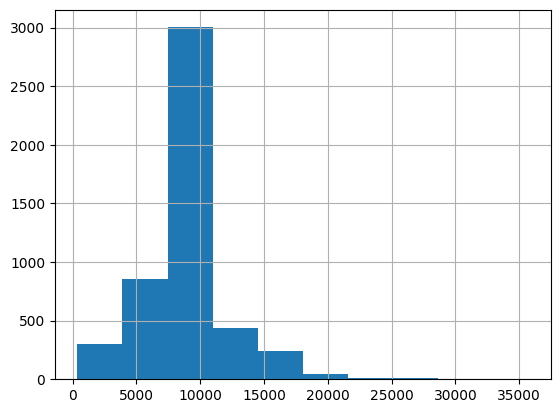

In [38]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist()

In [39]:
train_labels

2977    1
1139    1
5666    1
5824    1
4467    0
       ..
5218    1
4060    1
1346    0
3454    0
3582    1
Name: win_side, Length: 4900, dtype: int64

The below cells exceed Google's RAM limits. The code above attempts to split tokenization up

In [40]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [42]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [43]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [44]:
gc.collect()

4

In [45]:
##### setting hyper parameters 

#define a batch size
batch_size = 64

# define accumulation steps for use in gradient accumulation 
accumulation_steps = 4

# define learning rate for optimizer
learning_rate = 2e-5

# define regularization for optimizer
weight_decay=1e-4

# define Dropout Rate
dropout=0.5

# define epochs
epochs = 5

In [46]:
train_y

tensor([1, 1, 1,  ..., 0, 0, 1])

In [47]:
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [48]:
# freeze all the parameters

#original
#for param in bigbird.parameters():
   # param.requires_grad = False
#myswitch
for param in Deberta.parameters():
    param.requires_grad = False

In [49]:
class BERT_Arch(nn.Module):

    def __init__(self, Deberta):
        super(BERT_Arch, self).__init__()

        self.deberta = Deberta

        # dropout layer
        self.dropout = nn.Dropout(dropout)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 1)

    # define the forward pass
    def forward(self, sent_id, mask):

        # pass the inputs to the model
        if model_name == 'deberta':
            outputs = self.deberta(sent_id, attention_mask=mask, return_dict=True, output_hidden_states=True)
            cls_hs = outputs['hidden_states'][-1][:, 0]
        else:
            _, cls_hs = self.model(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        return x


In [50]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(Deberta)

# push the model to GPU
model = model.to(device)

In [51]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = learning_rate, weight_decay=weight_decay) 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
# Only use if NVIDIA Apex interface installed 





# initialize mixed-precision training after defining model and optimizer
# model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

In [53]:
# # compute the class weights
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(train_labels), 
                                     y=train_labels)

print("Class Weights:",class_weights)


weights_per_class = torch.tensor(class_weights, device=device)
weights = torch.zeros((batch_size, 1))

for idx, weight in enumerate(weights_per_class):
    weights[:, 0] = weight

# push to GPU
weights = weights.to(device)

Class Weights: [1.31791286 0.80565603]


In [54]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy = nn.BCEWithLogitsLoss()

In [55]:
# Instantiate GradScaler outside the train() function
scaler = GradScaler()

# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        sent_id, mask, labels = batch

        # Calculate the batch_weights using the labels of the current batch
        batch_labels = labels.to(device)
        batch_weights = torch.tensor([class_weights[label.item()] for label in batch_labels]).to(device)
        # batch_weights = weights_per_class[labels.to(device)]
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # Use autocast for mixed-precision training
        with autocast():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, batch_labels.unsqueeze(1).float())

        # Scale the loss and perform backward pass
        loss = (loss * batch_weights).mean()
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (step + 1) % accumulation_steps == 0:
            # Clip gradients and update optimizer
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            model.zero_grad()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds


In [56]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            #Issue here so I commented out
            #elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # Calculate the batch_weights using the labels of the current batch
        batch_labels = labels.to(device)
        batch_weights = torch.tensor([class_weights[label.item()] for label in batch_labels]).to(device)

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, batch_labels.unsqueeze(1).float())
            # Scale the loss by the batch_weights
            loss = (loss * batch_weights).mean()

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [57]:
# import gc
gc.collect()

87

In [58]:
##############################
#
#    RUN THE MODEL
#
##############################

# set initial loss to infinite
best_valid_loss = float('16')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of     77.

Evaluating...

Training Loss: 0.000
Validation Loss: 0.648

 Epoch 2 / 5
  Batch    50  of     77.

Evaluating...

Training Loss: 0.000
Validation Loss: 0.634

 Epoch 3 / 5
  Batch    50  of     77.

Evaluating...

Training Loss: 0.000
Validation Loss: 0.629

 Epoch 4 / 5
  Batch    50  of     77.

Evaluating...

Training Loss: 0.000
Validation Loss: 0.625

 Epoch 5 / 5
  Batch    50  of     77.

Evaluating...

Training Loss: 0.000
Validation Loss: 0.625


In [59]:
# #load weights of best model
# path = 'saved_weights.pt'
# # Move the model to CPU? 
# model = model.to(device)

# # Load weights and make predictions
# model.load_state_dict(torch.load(path, map_location=torch.device(device)))


#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [60]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# Move to CPU
# get predictions for test data
# with torch.no_grad():
#     preds = model(test_seq.to('cpu'), test_mask.to('cpu'))
#     preds = preds.detach().cpu().numpy()

OutOfMemoryError: ignored

In [ ]:
gc.collect()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
preds

In [ ]:
del(model)
torch.cuda.empty_cache()

In [ ]:
gc.collect()